In [4]:
#Task1
import pandas as pd

# Load the dataset(place the input file in same notebook folder)
file_path = 'Data1P_05_105_06_106.xlsx'
df = pd.read_excel(file_path)

# Drop the columns and rows with all NaN values
df_cleaned = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Transpose the DataFrame and set the first row as the header
df_transposed = df_cleaned.T
header = df_transposed.iloc[0]
df_transposed = df_transposed[1:]
df_transposed.columns = header

# Reset the index
df_transposed.reset_index(drop=True, inplace=True)

# Rename columns to more convenient names and the 'nan' column to 'Gender_F' if it exists
column_mapping = {
    'What is your height in inches?': 'Height',
    'What is your weight in pounds?': 'Weight',
    'What is your age in # of months?': 'Age(Months)',
    'What is your gender': 'Gender_M',
    'nan': 'Gender_F',
}
df_transposed.rename(columns=column_mapping, inplace=True)

# Drop the first row as it is not a data record
df_transposed = df_transposed.drop(0)

# Specify columns to convert to numeric types
cols_to_convert = ['Height', 'Weight', 'Age(Months)', 'Gender_M']
# Include 'Gender_F' only if it exists
if 'Gender_F' in df_transposed.columns:
    cols_to_convert.append('Gender_F')

# Convert specified columns to numeric types and handle any conversion errors
df_transposed[cols_to_convert] = df_transposed[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Handle missing values by imputing with the mean value for numeric columns
for col in cols_to_convert:
    df_transposed[col].fillna(df_transposed[col].mean(), inplace=True)

# Convert 1 to 'M' and 0 to 'F' in the Gender column
if 'Gender_F' in df_transposed.columns:
    df_transposed['Gender'] = df_transposed.apply(
        lambda row: 'M' if row['Gender_M'] == 1 else 'F' if row['Gender_F'] == 1 else 'Unknown', axis=1)
    # Drop the redundant Gender columns
    df_transposed.drop(['Gender_M', 'Gender_F'], axis=1, inplace=True)
else:
    df_transposed['Gender'] = df_transposed['Gender_M'].apply(lambda x: 'M' if x == 1 else 'F')
    df_transposed.drop(['Gender_M'], axis=1, inplace=True)

# Select only the required columns: 'Height', 'Weight', 'Age(Months)', 'Gender'
df_final = df_transposed[['Height', 'Weight', 'Age(Months)', 'Gender']]

# Save the final cleaned dataset to 'ClassData.csv'
output_file_path = 'ClassData.csv'
df_final.to_csv(output_file_path, index=False)


In [5]:
#Task-2: a & b
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the cleaned DataFrame 'df_final' from the previous step
# Assuming df_final is already loaded

# Extract features and target variable from DataFrame
X = df_final[['Height', 'Weight', 'Age(Months)']]
y = df_final['Gender']

# Split the dataset into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get user inputs
similarity_measurement = input("Enter Similarity Measurement (C for Cartesian, M for Manhattan, K for Minkowski): ").upper()
order = int(input("Enter Order (1-5): "))
k = int(input("Enter Value of K (1-5): "))

# Set p (parameter for Minkowski distance) based on the similarity measurement
p = 2  # Default for Cartesian
if similarity_measurement == 'M':
    p = 1  # Manhattan distance
elif similarity_measurement == 'K':
    p = order  # Minkowski distance with specified order

# Initialize the model with the specified parameters
model = KNeighborsClassifier(n_neighbors=k, p=p)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict the genders for the test set
predictions = model.predict(X_test_scaled)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions, labels=['M', 'F'])
print("Confusion Matrix:")
print(conf_matrix)

# Print the predictions for different values of K and distance measures for the 20% test data
print("Predictions:")
print(predictions)

Enter Similarity Measurement (C for Cartesian, M for Manhattan, K for Minkowski): C
Enter Order (1-5): 2
Enter Value of K (1-5): 4
Accuracy: 75.00%
Confusion Matrix:
[[7 1]
 [3 5]]
Predictions:
['F' 'M' 'M' 'M' 'M' 'F' 'F' 'M' 'F' 'M' 'M' 'F' 'M' 'M' 'M' 'F']


In [6]:
#Task-3: a & b
import numpy as np
import math
from collections import Counter

def cartesian_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1/p)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix(y_true, y_pred, labels=['M', 'F']):
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        index_true = labels.index(true_label)
        index_pred = labels.index(pred_label)
        matrix[index_true, index_pred] += 1
    return matrix

def knn_predict(X_train, y_train, x_test, k, distance_func, *args):
    distances = [distance_func(x_train, x_test, *args) for x_train in X_train]
    k_neighbors = np.argsort(distances)[:k]
    k_labels = [y_train[i] for i in k_neighbors]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

# Extract features and target variable from DataFrame
X = df_final[['Height', 'Weight', 'Age(Months)']].values
y = df_final['Gender'].values

# Split the dataset into 80% training and 20% test
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Get user inputs
similarity_measurement = input("Enter Similarity Measurement (C for Cartesian, M for Manhattan, K for Minkowski): ").upper()
order = int(input("Enter Order (1-5): "))
k = int(input("Enter Value of K (1-5): "))

# Set distance function and additional arguments based on the similarity measurement
if similarity_measurement == 'C':
    distance_func = cartesian_distance
    args = []
elif similarity_measurement == 'M':
    distance_func = manhattan_distance
    args = []
else:  # 'K'
    distance_func = minkowski_distance
    args = [order]

# Predict the genders for the test set
predictions = [knn_predict(X_train, y_train, x, k, distance_func, *args) for x in X_test]

# Calculate and print the accuracy
acc = accuracy(y_test, predictions)
print(f"Accuracy: {acc * 100:.2f}%")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the predictions for different values of K and distance measures for the 20% test data
print("Predictions:")
print(predictions)


Enter Similarity Measurement (C for Cartesian, M for Manhattan, K for Minkowski): C
Enter Order (1-5): 3
Enter Value of K (1-5): 3
Accuracy: 50.00%
Confusion Matrix:
[[7 3]
 [5 1]]
Predictions:
['F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M']


In [7]:
#Task-4: 1 test record
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# The given record to predict
record = np.array([[65, 150, 300]])
record_scaled = scaler.transform(record)  # Assuming 'scaler' is already defined

# Loop over different distance metrics and k values
for metric in ['euclidean', 'manhattan', 'minkowski']:
    for k in range(1, 6):
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=2 if metric == 'minkowski' else None)
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)

        # Accuracy, Confusion Matrix, and Prediction for the given record
        acc = accuracy_score(y_test, predictions)
        conf_mat = confusion_matrix(y_test, predictions, labels=['M', 'F'])
        prediction_for_record = model.predict(record_scaled)

        print(f"Library Version - Metric: {metric}, k: {k}")
        print(f"Accuracy: {acc * 100:.2f}%")
        print("Confusion Matrix:")
        print(conf_mat)
        print(f"Prediction for the record: {prediction_for_record[0]}")
        print("="*50)


Library Version - Metric: euclidean, k: 1
Accuracy: 68.75%
Confusion Matrix:
[[8 2]
 [3 3]]
Prediction for the record: M
Library Version - Metric: euclidean, k: 2
Accuracy: 75.00%
Confusion Matrix:
[[7 3]
 [1 5]]
Prediction for the record: F
Library Version - Metric: euclidean, k: 3
Accuracy: 68.75%
Confusion Matrix:
[[9 1]
 [4 2]]
Prediction for the record: M
Library Version - Metric: euclidean, k: 4
Accuracy: 75.00%
Confusion Matrix:
[[9 1]
 [3 3]]
Prediction for the record: M
Library Version - Metric: euclidean, k: 5
Accuracy: 68.75%
Confusion Matrix:
[[10  0]
 [ 5  1]]
Prediction for the record: M
Library Version - Metric: manhattan, k: 1
Accuracy: 62.50%
Confusion Matrix:
[[8 2]
 [4 2]]
Prediction for the record: M
Library Version - Metric: manhattan, k: 2
Accuracy: 62.50%
Confusion Matrix:
[[6 4]
 [2 4]]
Prediction for the record: F
Library Version - Metric: manhattan, k: 3
Accuracy: 68.75%
Confusion Matrix:
[[8 2]
 [3 3]]
Prediction for the record: M
Library Version - Metric: ma

C:\Users\rohit\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:
# Loop over different distance metrics and k values
for metric, distance_func, args in [('C', cartesian_distance, []), ('M', manhattan_distance, []), ('K', minkowski_distance, [2])]:
    for k in range(1, 6):
        predictions = [knn_predict(X_train, y_train, x, k, distance_func, *args) for x in X_test]

        # Accuracy, Confusion Matrix, and Prediction for the given record
        acc = accuracy(y_test, predictions)
        conf_mat = confusion_matrix(y_test, predictions)
        prediction_for_record = knn_predict(X_train, y_train, record[0], k, distance_func, *args)

        print(f"Scratch Version - Metric: {metric}, k: {k}")
        print(f"Accuracy: {acc * 100:.2f}%")
        print("Confusion Matrix:")
        print(conf_mat)
        print(f"Prediction for the record: {prediction_for_record}")
        print("="*50)


Scratch Version - Metric: C, k: 1
Accuracy: 75.00%
Confusion Matrix:
[[3 3]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: C, k: 2
Accuracy: 75.00%
Confusion Matrix:
[[3 3]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: C, k: 3
Accuracy: 50.00%
Confusion Matrix:
[[1 5]
 [3 7]]
Prediction for the record: M
Scratch Version - Metric: C, k: 4
Accuracy: 56.25%
Confusion Matrix:
[[1 5]
 [2 8]]
Prediction for the record: M
Scratch Version - Metric: C, k: 5
Accuracy: 56.25%
Confusion Matrix:
[[0 6]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: M, k: 1
Accuracy: 75.00%
Confusion Matrix:
[[3 3]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: M, k: 2
Accuracy: 75.00%
Confusion Matrix:
[[3 3]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: M, k: 3
Accuracy: 68.75%
Confusion Matrix:
[[2 4]
 [1 9]]
Prediction for the record: M
Scratch Version - Metric: M, k: 4
Accuracy: 62.50%
Confusion Matrix:
[[1 5]
 [1 9]]
Prediction f

C:\Users\rohit\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


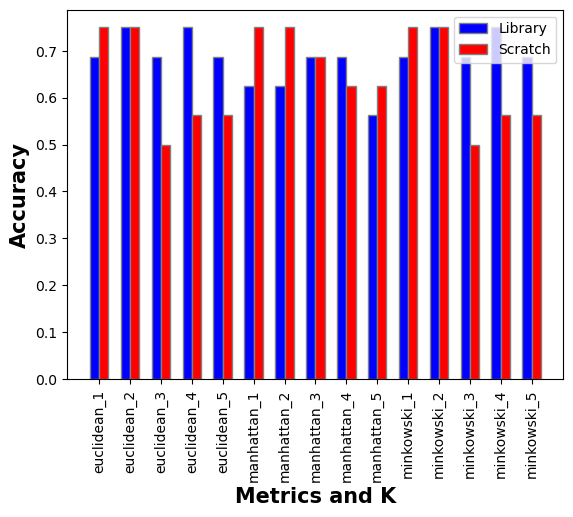

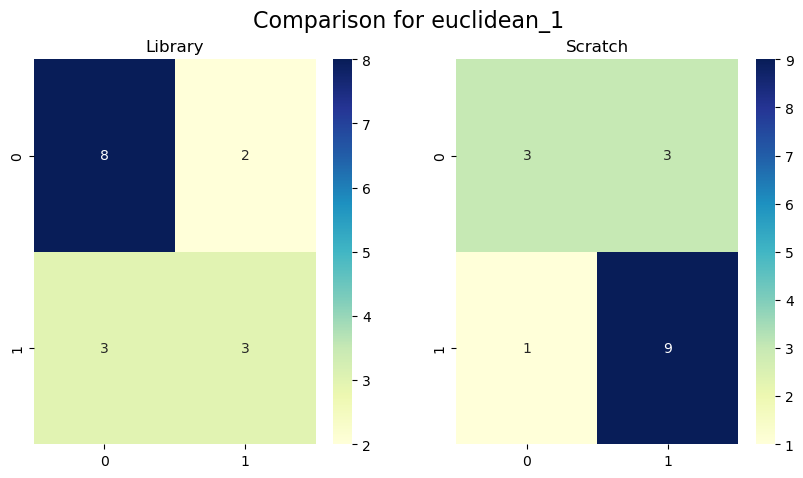

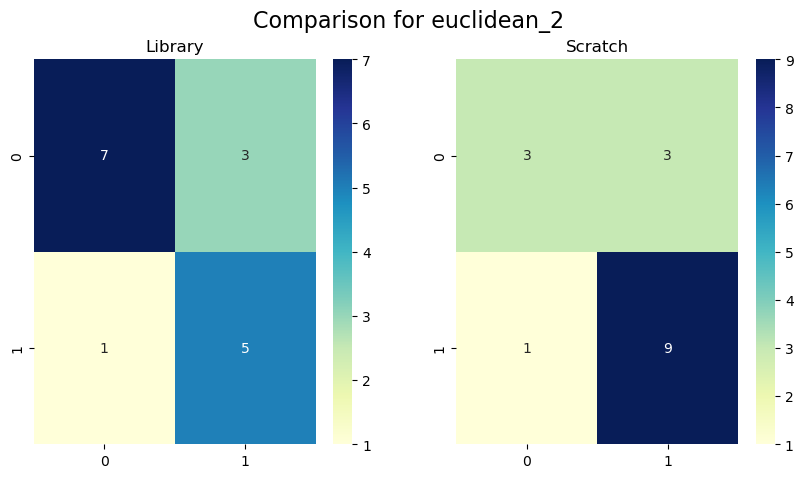

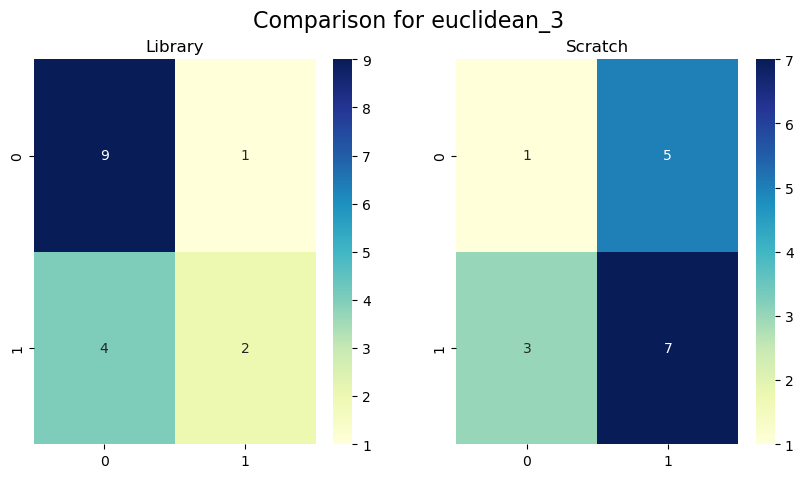

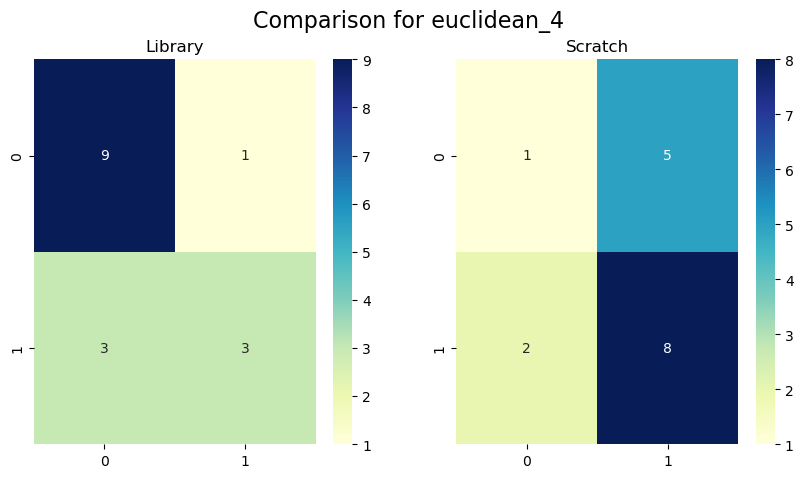

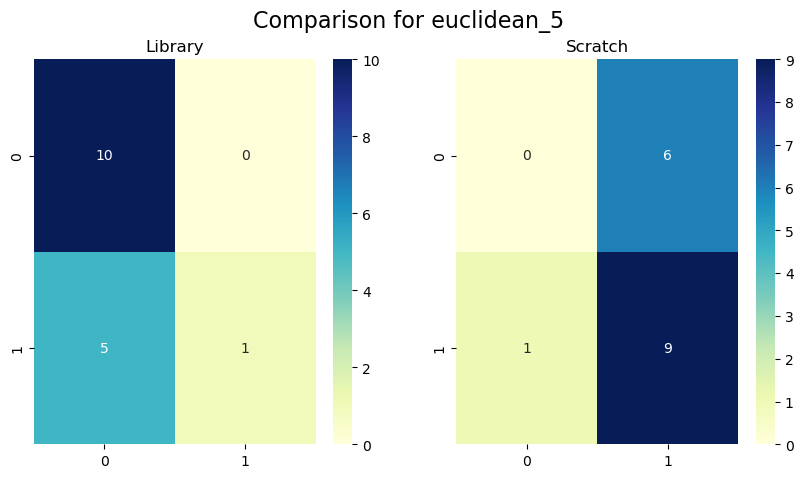

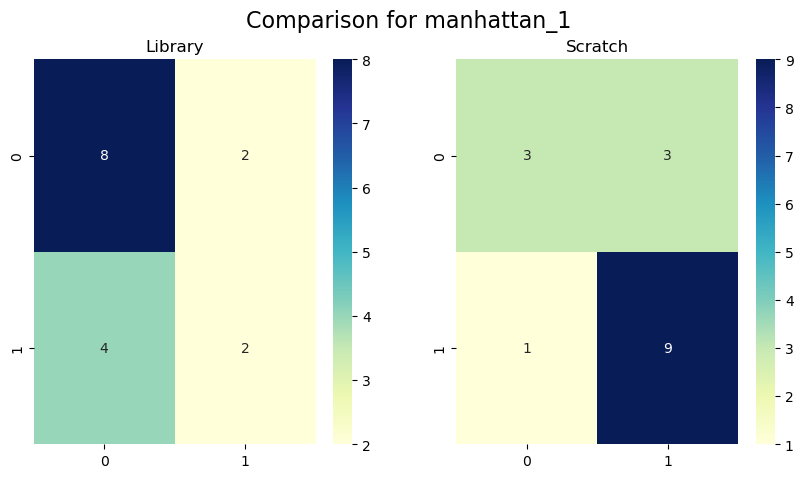

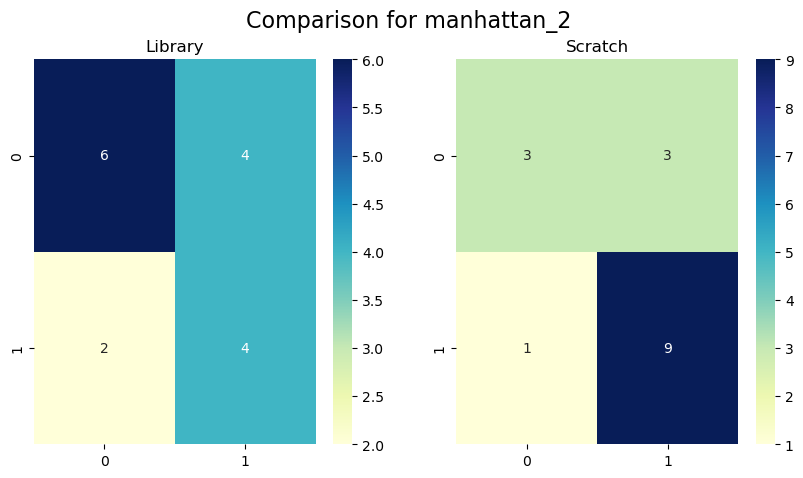

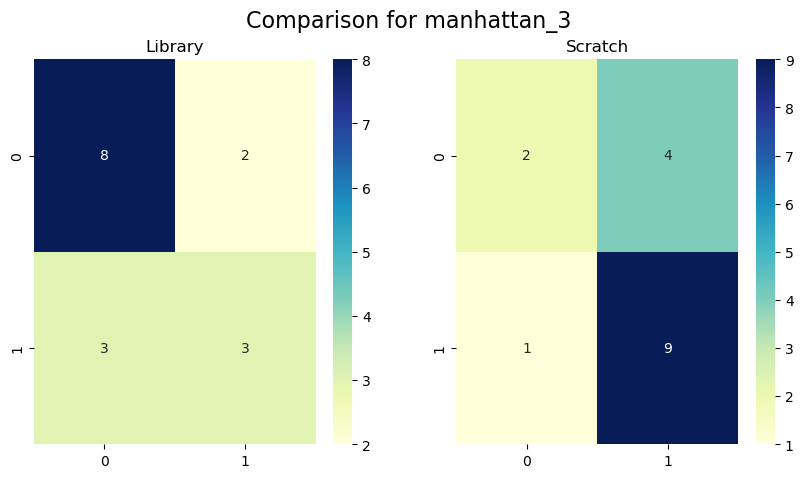

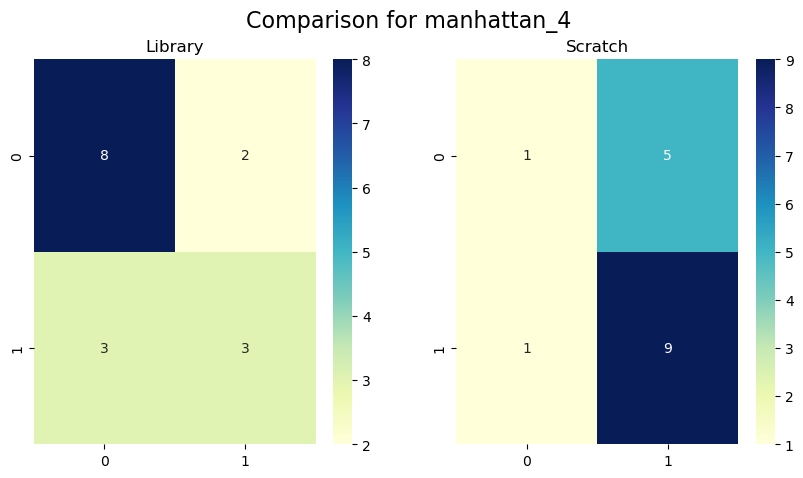

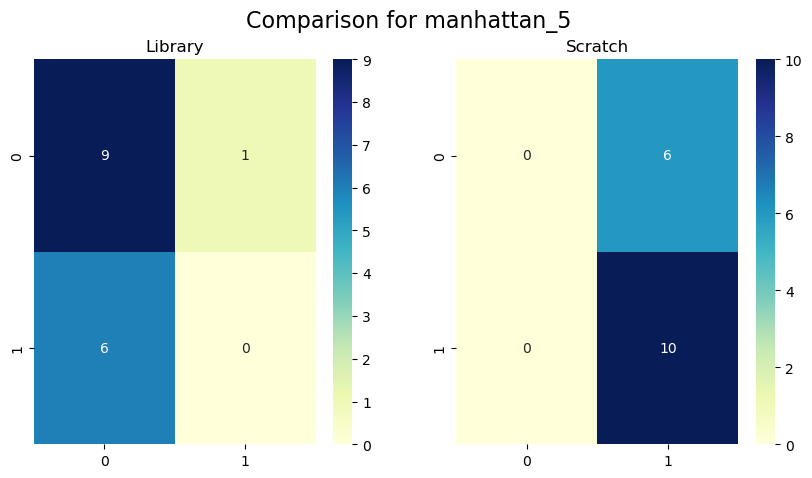

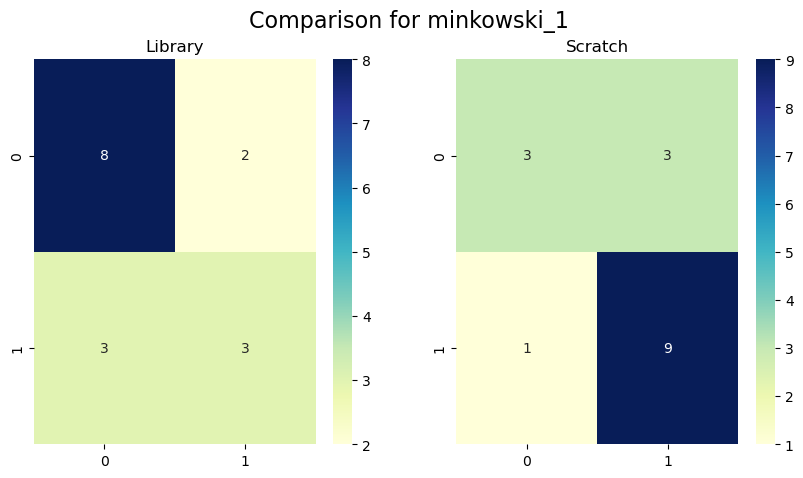

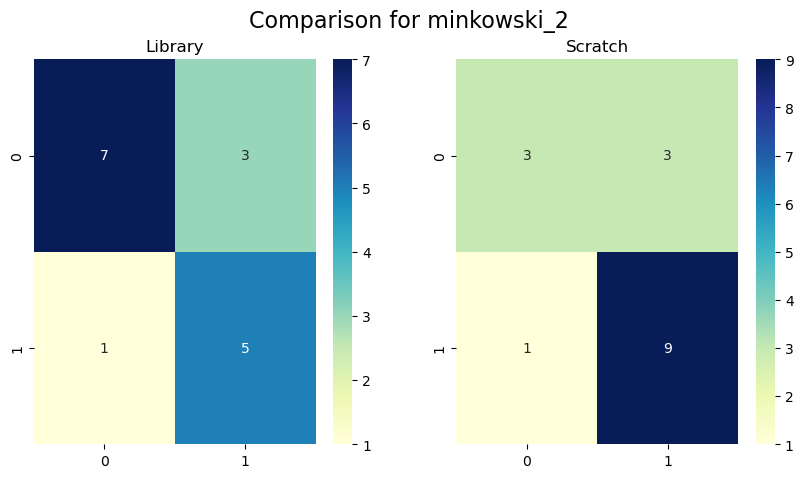

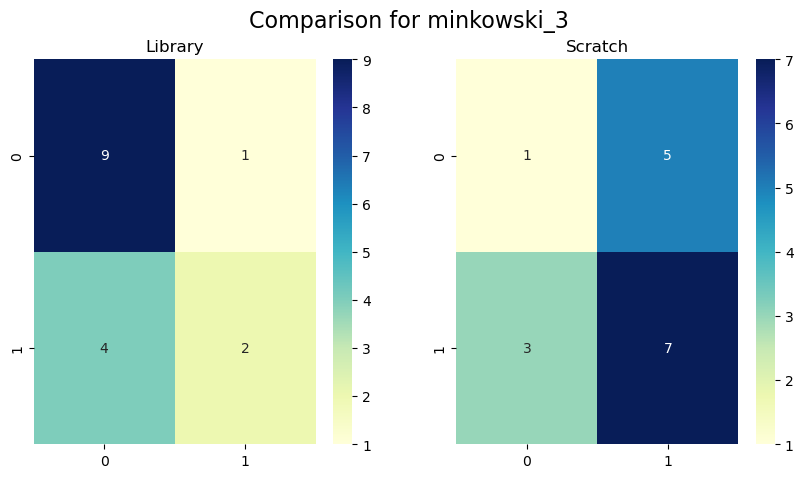

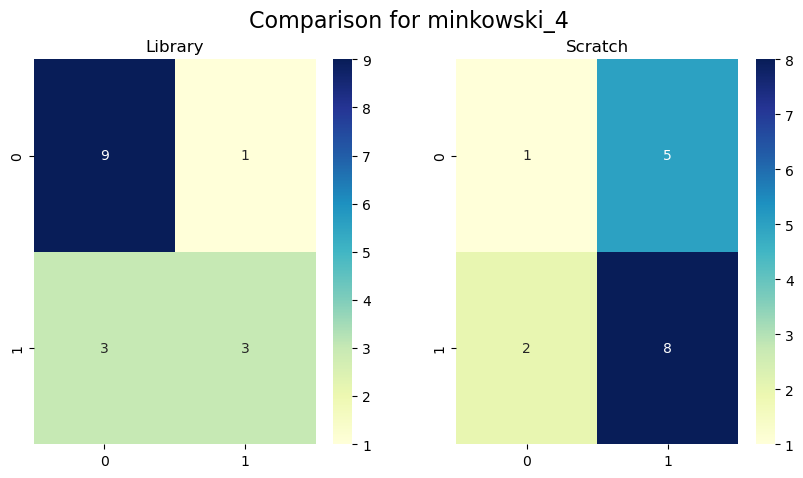

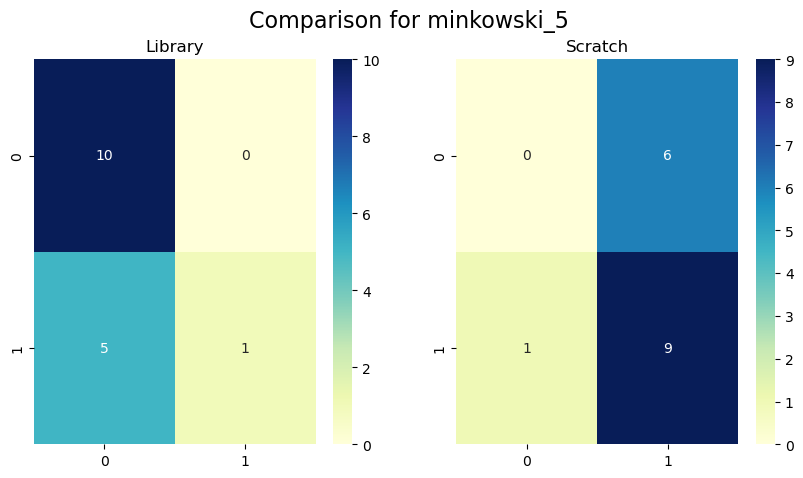

For euclidean_1:
Library Version Prediction: M
Scratch Version Prediction: M
For euclidean_2:
Library Version Prediction: F
Scratch Version Prediction: M
For euclidean_3:
Library Version Prediction: M
Scratch Version Prediction: M
For euclidean_4:
Library Version Prediction: M
Scratch Version Prediction: M
For euclidean_5:
Library Version Prediction: M
Scratch Version Prediction: M
For manhattan_1:
Library Version Prediction: M
Scratch Version Prediction: M
For manhattan_2:
Library Version Prediction: F
Scratch Version Prediction: M
For manhattan_3:
Library Version Prediction: M
Scratch Version Prediction: M
For manhattan_4:
Library Version Prediction: M
Scratch Version Prediction: M
For manhattan_5:
Library Version Prediction: M
Scratch Version Prediction: M
For minkowski_1:
Library Version Prediction: M
Scratch Version Prediction: M
For minkowski_2:
Library Version Prediction: F
Scratch Version Prediction: M
For minkowski_3:
Library Version Prediction: M
Scratch Version Prediction: M

In [9]:
#q4 plotting graphs for 1 test record
import matplotlib.pyplot as plt
import seaborn as sns

# The given record to predict
record = np.array([[65, 150, 300]])
record_scaled = scaler.transform(record)

results_library = {}
results_scratch = {}

# Loop over different distance metrics and k values
for metric in ['euclidean', 'manhattan', 'minkowski']:
    for k in range(1, 6):
        # Library Version
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=2 if metric == 'minkowski' else None)
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, predictions)
        conf_mat = confusion_matrix(y_test, predictions, labels=['M', 'F'])
        prediction_for_record = model.predict(record_scaled)
        results_library[f'{metric}_{k}'] = {'accuracy': acc, 'confusion_matrix': conf_mat, 'prediction_for_record': prediction_for_record}

        # Scratch Version
        distance_func = cartesian_distance if metric == 'euclidean' else manhattan_distance if metric == 'manhattan' else minkowski_distance
        args = [2] if metric == 'minkowski' else []
        predictions_scratch = [knn_predict(X_train, y_train, x, k, distance_func, *args) for x in X_test]
        acc_scratch = accuracy(y_test, predictions_scratch)
        conf_mat_scratch = confusion_matrix(y_test, predictions_scratch)
        prediction_for_record_scratch = knn_predict(X_train, y_train, record[0], k, distance_func, *args)
        results_scratch[f'{metric}_{k}'] = {'accuracy': acc_scratch, 'confusion_matrix': conf_mat_scratch, 'prediction_for_record': prediction_for_record_scratch}

# Plotting Comparison Graphs
metrics_k_combinations = list(results_library.keys())
accuracies_library = [results_library[combo]['accuracy'] for combo in metrics_k_combinations]
accuracies_scratch = [results_scratch[combo]['accuracy'] for combo in metrics_k_combinations]

barWidth = 0.3
r1 = np.arange(len(accuracies_library))
r2 = [x + barWidth for x in r1]

plt.bar(r1, accuracies_library, color='b', width=barWidth, edgecolor='grey', label='Library')
plt.bar(r2, accuracies_scratch, color='r', width=barWidth, edgecolor='grey', label='Scratch')

plt.xlabel('Metrics and K', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(accuracies_library))], metrics_k_combinations, rotation=90)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)

plt.legend()
plt.show()

# Plotting Confusion Matrix Comparison using Heatmaps
for combo in metrics_k_combinations:
    plt.figure(figsize=(10,5))
    plt.suptitle(f"Comparison for {combo}", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.heatmap(results_library[combo]['confusion_matrix'], annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Library")

    plt.subplot(1, 2, 2)
    sns.heatmap(results_scratch[combo]['confusion_matrix'], annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Scratch")

    plt.show()

# Displaying Predictions for the given record
for combo in metrics_k_combinations:
    print(f"For {combo}:")
    print(f"Library Version Prediction: {results_library[combo]['prediction_for_record'][0]}")
    print(f"Scratch Version Prediction: {results_scratch[combo]['prediction_for_record']}")
    print("="*50)


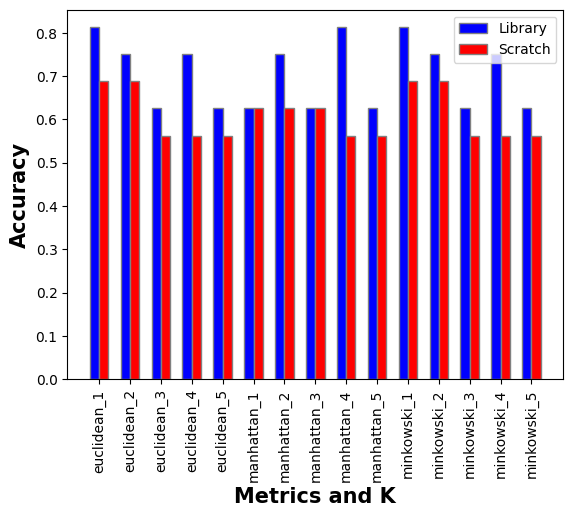

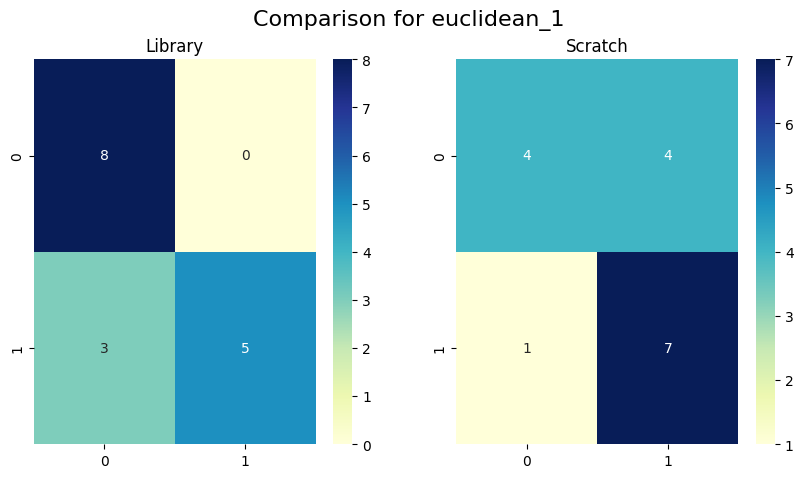

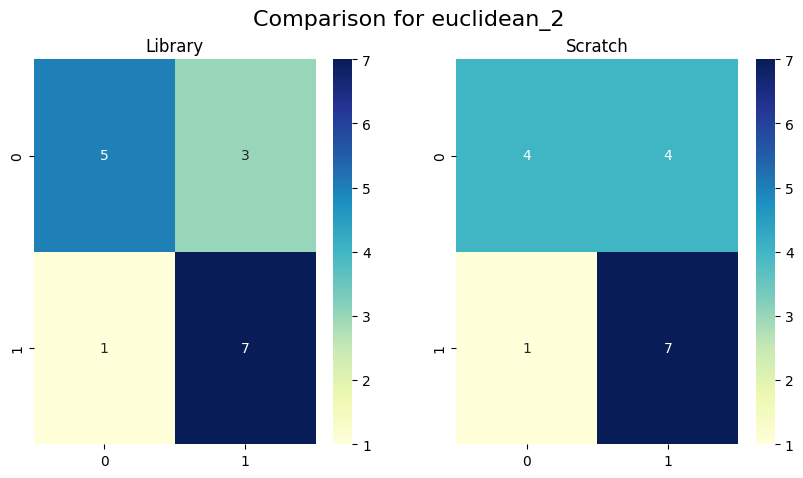

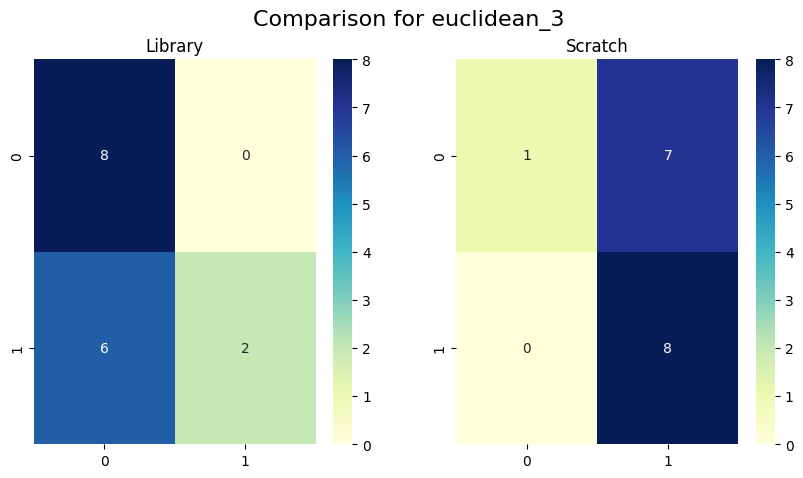

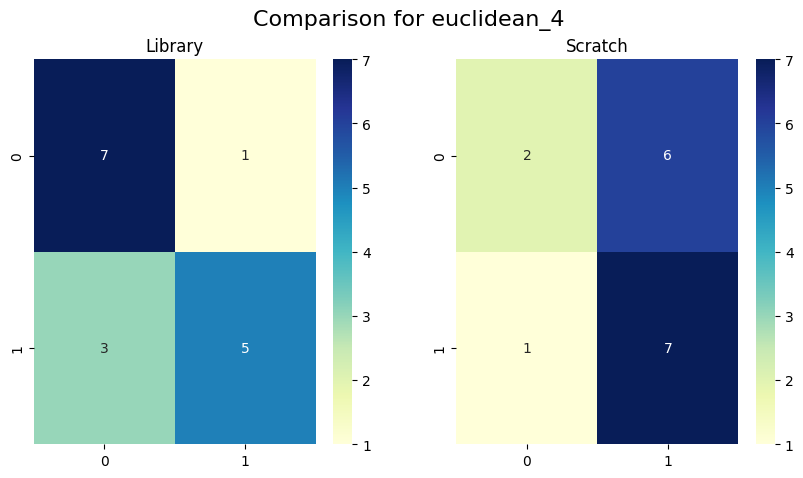

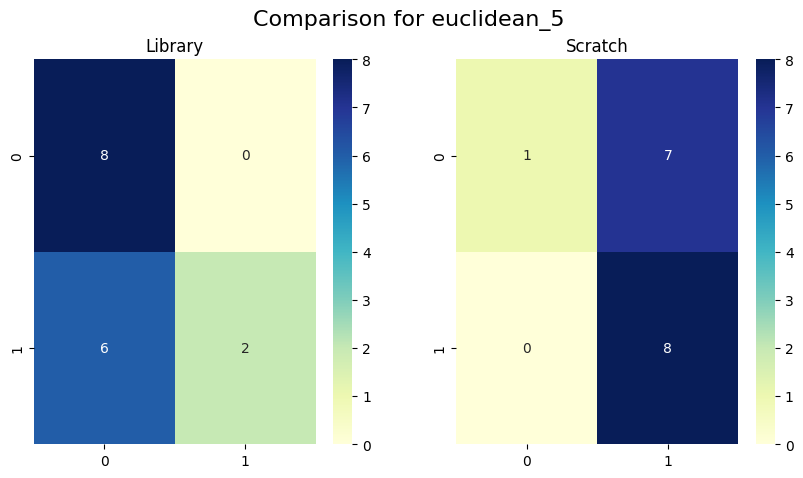

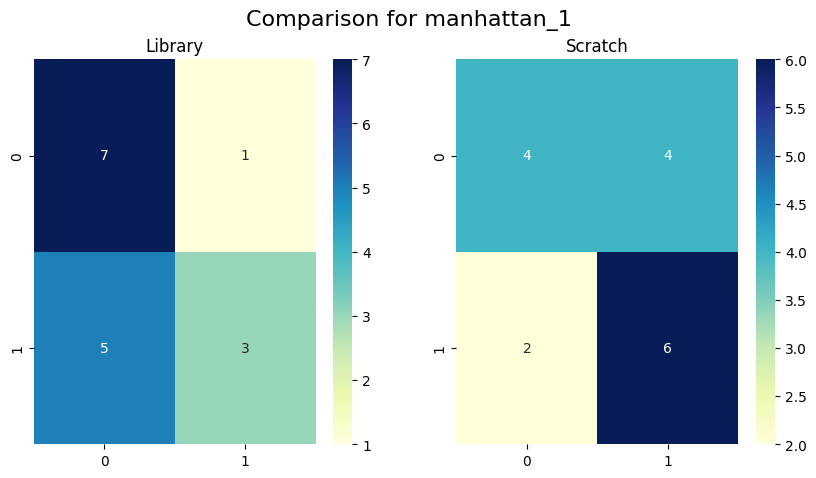

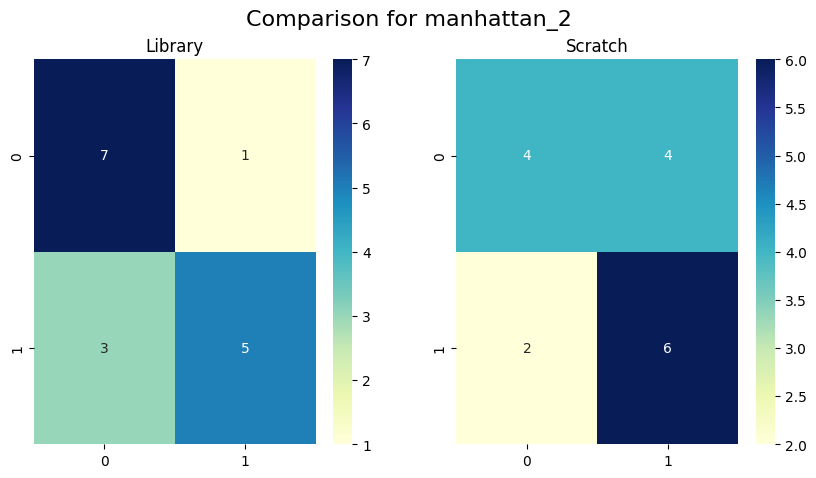

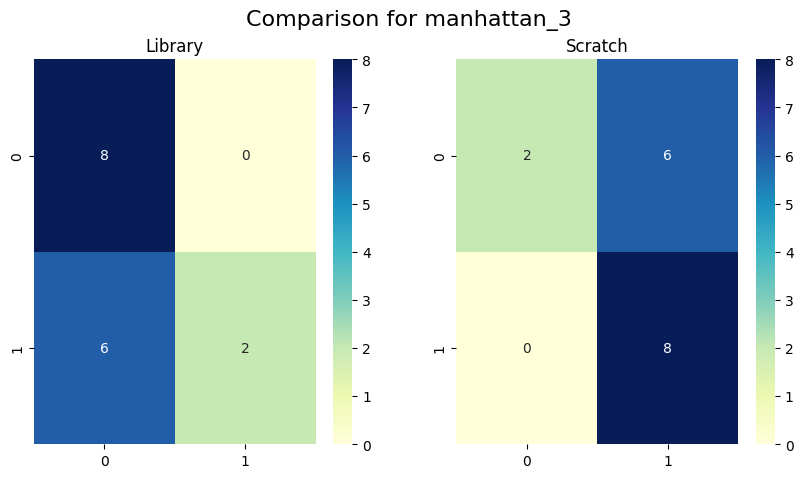

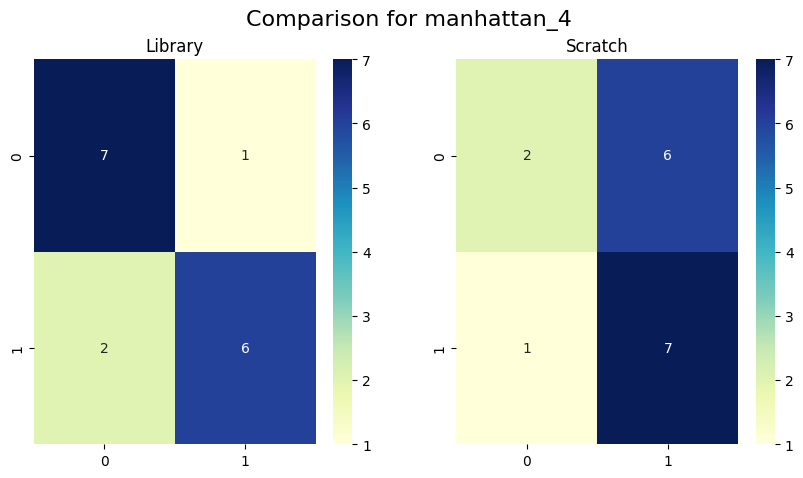

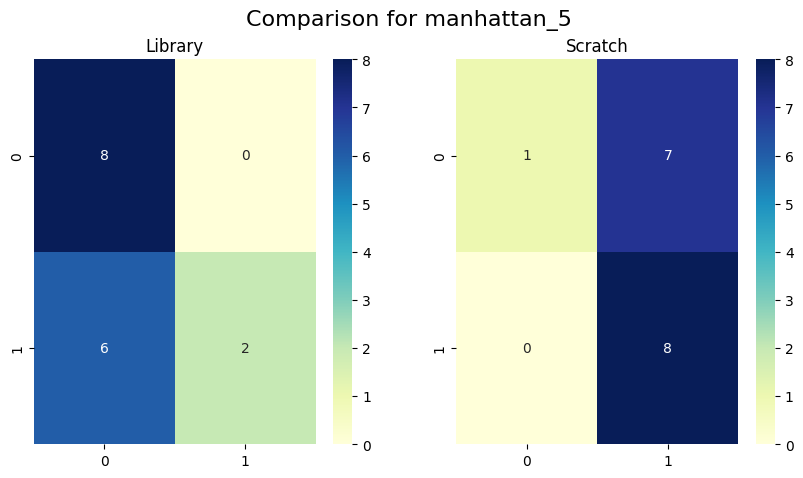

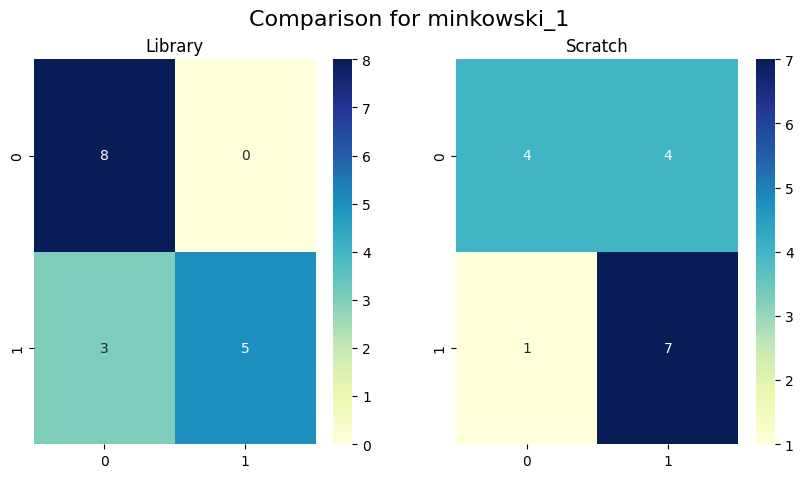

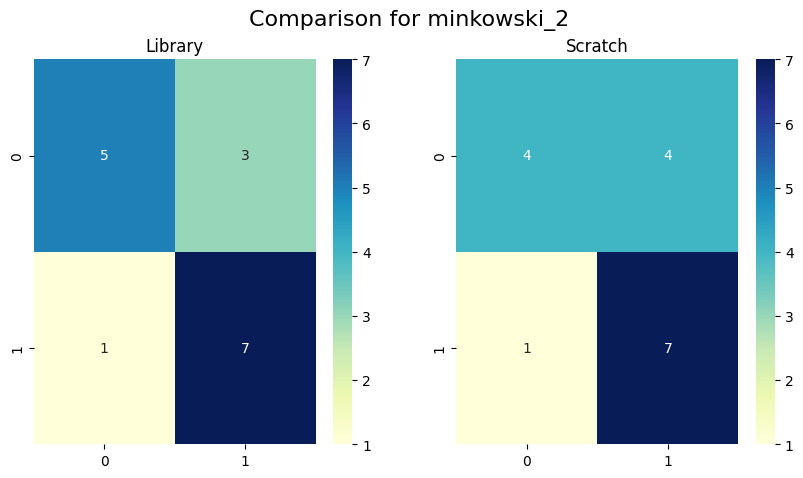

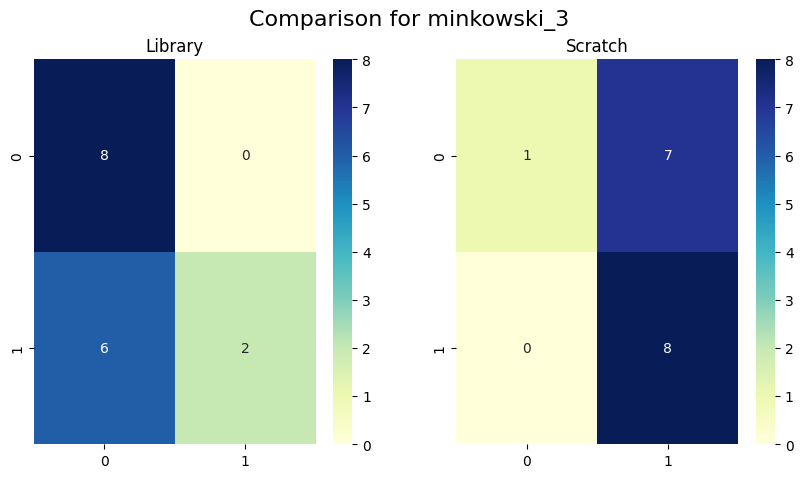

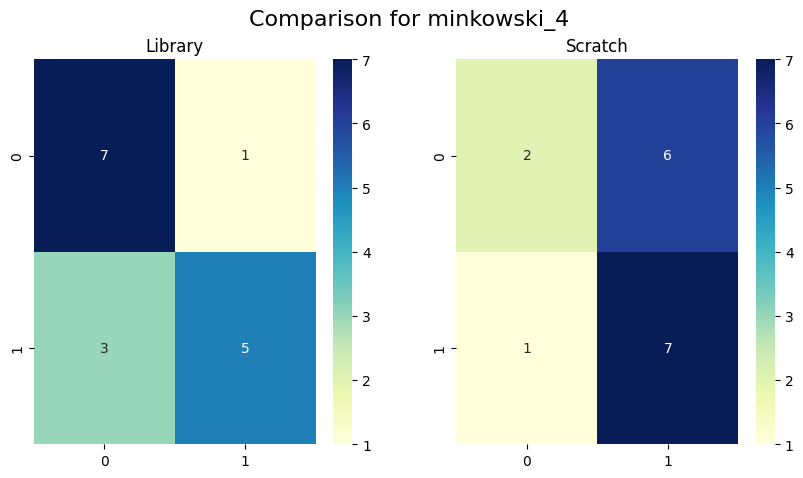

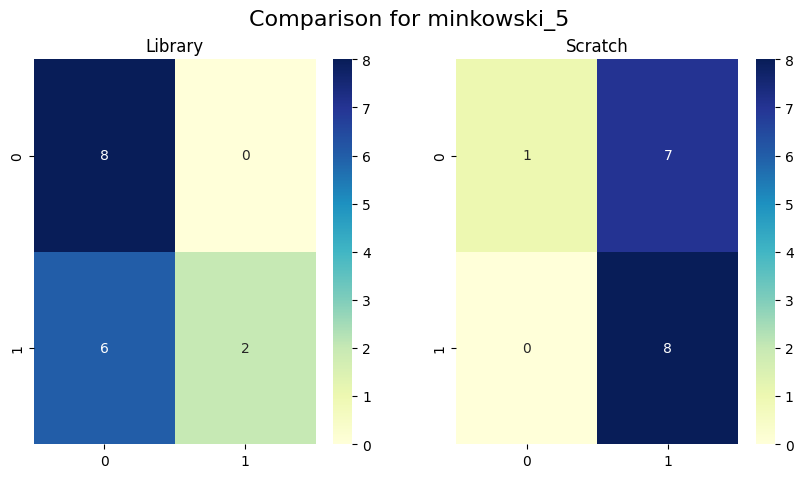

In [49]:
#q4 plotting graphs for whole2 0% test record
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

# Assuming df_final is already loaded with the cleaned data
X = df_final[['Height', 'Weight', 'Age(Months)']].values
y = df_final['Gender'].values

# Split the dataset into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Distance Functions
def cartesian_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1/p)

def knn_predict(X_train, y_train, x_test, k, distance_func, *args):
    distances = [distance_func(x_train, x_test, *args) for x_train in X_train]
    k_neighbors = np.argsort(distances)[:k]
    k_labels = [y_train[i] for i in k_neighbors]
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

results_library = {}
results_scratch = {}

# Loop over different distance metrics and k values
for metric in ['euclidean', 'manhattan', 'minkowski']:
    for k in range(1, 6):
        # Library Version
        model = KNeighborsClassifier(n_neighbors=k, metric=metric, p=2 if metric == 'minkowski' else None)
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, predictions)
        conf_mat = confusion_matrix(y_test, predictions, labels=['M', 'F'])
        results_library[f'{metric}_{k}'] = {'accuracy': acc, 'confusion_matrix': conf_mat}

        # Scratch Version
        distance_func = cartesian_distance if metric == 'euclidean' else manhattan_distance if metric == 'manhattan' else minkowski_distance
        args = [2] if metric == 'minkowski' else []
        predictions_scratch = [knn_predict(X_train, y_train, x, k, distance_func, *args) for x in X_test]
        acc_scratch = accuracy(y_test, predictions_scratch)
        conf_mat_scratch = confusion_matrix(y_test, predictions_scratch)
        results_scratch[f'{metric}_{k}'] = {'accuracy': acc_scratch, 'confusion_matrix': conf_mat_scratch}

# Plotting Comparison
metrics_k_combinations = list(results_library.keys())
accuracies_library = [results_library[combo]['accuracy'] for combo in metrics_k_combinations]
accuracies_scratch = [results_scratch[combo]['accuracy'] for combo in metrics_k_combinations]

barWidth = 0.3
r1 = np.arange(len(accuracies_library))
r2 = [x + barWidth for x in r1]

plt.bar(r1, accuracies_library, color='b', width=barWidth, edgecolor='grey', label='Library')
plt.bar(r2, accuracies_scratch, color='r', width=barWidth, edgecolor='grey', label='Scratch')

plt.xlabel('Metrics and K', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth/2 for r in range(len(accuracies_library))], metrics_k_combinations, rotation=90)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)

plt.legend()
plt.show()

# Plotting Confusion Matrix Comparison using Heatmaps
for combo in metrics_k_combinations:
    plt.figure(figsize=(10,5))
    plt.suptitle(f"Comparison for {combo}", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.heatmap(results_library[combo]['confusion_matrix'], annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Library")

    plt.subplot(1, 2, 2)
    sns.heatmap(results_scratch[combo]['confusion_matrix'], annot=True, cmap="YlGnBu", fmt='g')
    plt.title("Scratch")

    plt.show()
